# Supermarket sales forecasting 

- Build a model for forecasting total sales based on factors such as location, product type, promotions, etc. 
- Sample data: Supermarket Sales Dataset (Kaggle). 
- Analyze and prepare the data. 
- Use several (at least two) algorithms and compare their score with appropriate metrics and analyze the results.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text, plot_tree, export_graphviz

import graphviz

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

from lightgbm import LGBMRegressor, create_tree_digraph

from sklearn.linear_model import ElasticNet


seed = 42

# 0. Selection and loading of the data set from Kaggle

The following dataset was selected [walmartcleaned](https://www.kaggle.com/datasets/ujjwalchowdhury/walmartcleaned/data), because:
 - it has features closely equivalent to the mentioned ones:  
   - location is not explicit, but there are 45 store;
   - product type is missing, but the Department plays a similar role;
   - promotions are present in the form of the 5 'MarkDown fields' 
 - it has a significant amount of data  421_570 rows × 17 columns
 - seems to be real world data


In [2]:
df_original = pd.read_csv("./Walmart/walmart.csv")
df_original.head()
df_original.tail()

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
421565,423281,45,2012-10-26,0,13.0,26240.14,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421566,423282,45,2012-10-26,0,16.0,2660.02,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421567,423283,45,2012-10-26,0,32.0,4131.54,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421568,423284,45,2012-10-26,0,83.0,717.82,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421569,423285,45,2012-10-26,0,98.0,1076.80,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221


First of all let's parse the Date to pandas native date format and use it as index.

The Temperature could also be parsed to Celsium for convinience.

The Unnamed column which serves as an ID and is likely an index in an original uncleaned data set also seems not necessary so for faster manipulatiins a dataframe copy without it is also created:

In [3]:
df_original["Date"] = pd.to_datetime(df_original["Date"])
df_original.set_index("Date", inplace=False)
df = df_original.copy()
df["Temperature"] = (df["Temperature"] - 32) * 5.0 / 9.0
del df["Unnamed: 0"]

df.tail()

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
421565,45,2012-10-26,0,13.0,26240.14,14.916667,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421566,45,2012-10-26,0,16.0,2660.02,14.916667,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421567,45,2012-10-26,0,32.0,4131.54,14.916667,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421568,45,2012-10-26,0,83.0,717.82,14.916667,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421569,45,2012-10-26,0,98.0,1076.80,14.916667,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221


# 1. Data Analysis
## 1.1. Initial inspection of the data

First of all let's note the type of each feature, its range and if needed consult for its meaning.


In [4]:
df.describe()

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
count,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,2011-06-18 08:30:31.963375360,0.070358,44.260317,15981.258123,15.605588,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,2.410088,136727.915739
min,1.000000,2010-02-05 00:00:00,0.000000,1.000000,-4988.940000,-18.922222,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,1.000000,34875.000000
25%,11.000000,2010-10-08 00:00:00,0.000000,18.000000,2079.650000,8.155556,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,2.000000,93638.000000
50%,22.000000,2011-06-17 00:00:00,0.000000,37.000000,7612.030000,16.716667,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,3.000000,140167.000000
75%,33.000000,2012-02-24 00:00:00,0.000000,74.000000,20205.852500,23.488889,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,3.000000,202505.000000
max,45.000000,2012-10-26 00:00:00,1.000000,99.000000,693099.360000,37.855556,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,3.000000,219622.000000
std,12.785297,NaN,0.255750,30.492054,22711.183519,10.248851,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,0.666337,60980.583328


In [5]:
# df.info()

In [6]:
def describe_columns(df):
    summary = pd.DataFrame(
        {
            "dtype": df.dtypes,
            "missing": df.isna().sum(),
            "unique": df.nunique(),
            "min": df.apply(
                lambda x: x.min() if np.issubdtype(x.dtype, np.number) else None
            ),
            "max": df.apply(
                lambda x: x.max() if np.issubdtype(x.dtype, np.number) else None
            ),
        }
    )
    return summary


describe_columns(df)

,dtype,missing,unique,min,max
Store,int64,0,45,1.000000,45.000000
Date,datetime64[ns],0,143,NaN,NaN
IsHoliday,int64,0,2,0.000000,1.000000
Dept,float64,0,81,1.000000,99.000000
Weekly_Sales,float64,0,359464,-4988.940000,693099.360000
Temperature,float64,0,3528,-18.922222,37.855556
Fuel_Price,float64,0,892,2.472000,4.468000
MarkDown1,float64,0,2278,0.000000,88646.760000
MarkDown2,float64,0,1499,-265.760000,104519.540000
MarkDown3,float64,0,1662,-29.100000,141630.610000


As the data is alredy cleaned we see that there are no missing data at all. 

(Judging by the last index 423285 on row 421569, we can guess that 1716 entries have been cleaned)

1. Department and Store 

Dept
1.0     45
2.0     45
3.0     45
4.0     45
5.0     45
        ..
95.0    45
96.0    45
97.0    45
98.0    45
99.0    37
Name: Store, Length: 81, dtype: int64
Store
1     77
2     78
3     72
4     78
5     72
6     77
7     76
8     76
9     73
10    77
11    78
12    75
13    79
14    77
15    79
16    76
17    76
18    78
19    79
20    78
21    77
22    76
23    77
24    77
25    77
26    76
27    78
28    77
29    77
30    64
31    76
32    77
33    63
34    78
35    74
36    63
37    62
38    63
39    75
40    77
41    77
42    62
43    61
44    62
45    74
Name: Dept, dtype: int64


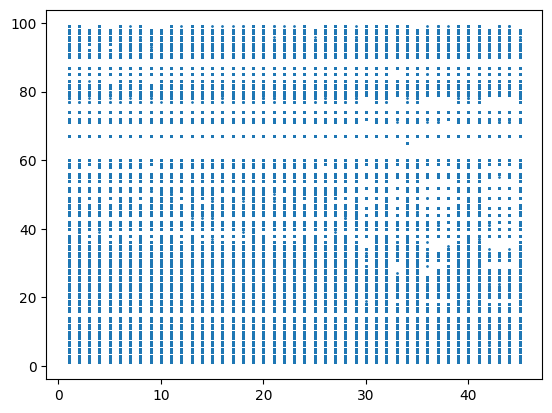

In [7]:
deperatment_freq_over_stores = df.groupby(by="Dept")["Store"].nunique()
print(deperatment_freq_over_stores)
number_of_departments_per_store = df.groupby(by="Store")["Dept"].nunique()
print(number_of_departments_per_store)

plt.scatter(df["Store"], df["Dept"], s=1)

The distribution of the departments across stores is quite uniform.
An agregation of the departments in a store and grouping of the data from all stores for a given department are both meaningful.

Let's see the distribution of the sales across these 2 features, for a given date:

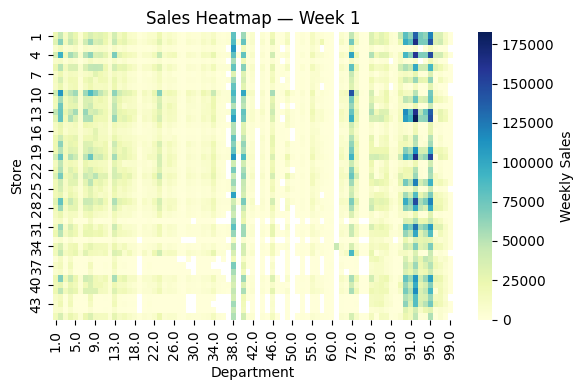

In [8]:
grouped = (df.groupby(["Store", "Dept"]))["Weekly_Sales"].mean().reset_index()
pivot = grouped.pivot(index="Store", columns="Dept", values="Weekly_Sales")

plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=False, cmap="YlGnBu", cbar_kws={"label": "Weekly Sales"})
plt.title(f"Sales Heatmap — Week 1")
plt.ylabel("Store")
plt.xlabel("Department")
plt.tight_layout()
plt.show()

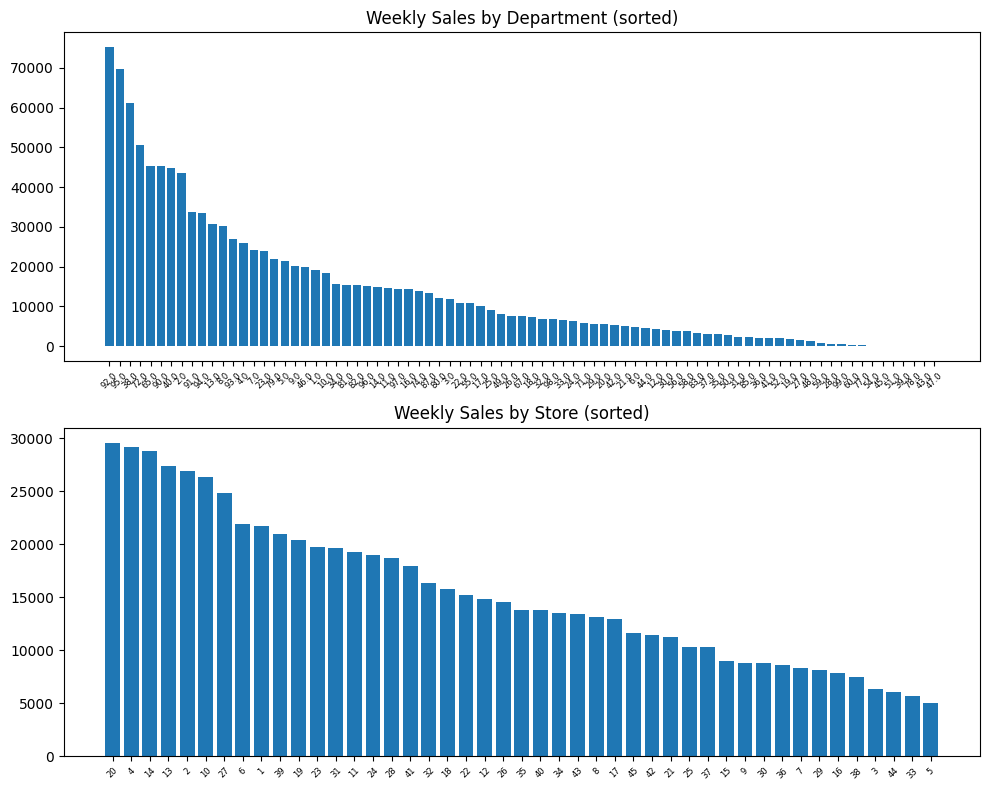

In [9]:
total_by_store = (
    (df.groupby(["Store"]))["Weekly_Sales"].mean().reset_index()
)  # total sales per store summed over over all departments and dates
total_by_store_sorted = total_by_store.sort_values(by="Weekly_Sales", ascending=False)

total_by_dept = (
    (df.groupby(["Dept"]))["Weekly_Sales"].mean().reset_index()
)  # total sales per department summed over over all stores and dates
total_by_dept_sorted = total_by_dept.sort_values(by="Weekly_Sales", ascending=False)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# by Dept
axes[0].bar(
    total_by_dept_sorted["Dept"].astype(str), total_by_dept_sorted["Weekly_Sales"]
)
axes[0].set_title("Weekly Sales by Department (sorted)")
axes[0].tick_params(axis="x", rotation=45, labelsize=6)

# by Store
axes[1].bar(
    total_by_store_sorted["Store"].astype(str), total_by_store_sorted["Weekly_Sales"]
)
axes[1].set_title("Weekly Sales by Store (sorted)")
axes[1].tick_params(axis="x", rotation=45, labelsize=6)

plt.tight_layout()
plt.show()

We see a higher variance over the departments than the stores.

CPI is Consumer price index ... measures the average change over time in prices paid by urban consumers for a market basket of goods and services
Lets see its trend over time 

In [80]:
# df_store_1 = df[df['Store'] == 31]

# ax = df.plot(
#     x="Date", y="CPI", kind="scatter", figsize=(12, 5), s=2, color="blue", label="CPI"
# )
# plt.xticks(rotation=45)
# ax.set_xticks(ax.get_xticks()[::5])
# plt.tight_layout()

In [79]:
# df.plot(x="Date", y="CPI", kind="line", figsize=(15, 5))

To check if Type and Size quantify the sales - lets observe some polots

A complete scatter matrix could also be created (in ~10min). But let's focus more on the time dependence.
For that we extract the relative week from each date.
Also as the Department 

In [12]:
def smart_aggregate(df, group_cols=["Store", "Date"], sum_col="Weekly_Sales"):
    """
    Automatically handle columns based on their consistency
    """
    # Get all non-grouping columns except the sum column
    other_cols = [col for col in df.columns if col not in group_cols and col != sum_col]

    agg_dict = {sum_col: "sum"}  # Always sum the sales

    for col in other_cols:
        # Check if column has consistent values within groups
        is_consistent = df.groupby(group_cols)[col].nunique().max() == 1

        if is_consistent:
            # Take first value (all are same)
            agg_dict[col] = "first"
        else:
            print(f"Column '{col}' has conflicting values within groups.")
            # Choose appropriate aggregation based on dtype
            if pd.api.types.is_numeric_dtype(df[col]):
                agg_dict[col] = "mean"  # Average for numeric
            else:
                # For categorical conflicts - just throw
                raise ValueError(
                    f"Explicit categorical non numeric values in column '{col}'"
                )

    return df.groupby(group_cols).agg(agg_dict).reset_index()


# grouped = smart_aggregate(df, ['Store', 'Date'], 'Weekly_Sales')
# print(grouped.head())

Column 'Dept' has conflicting values within groups.


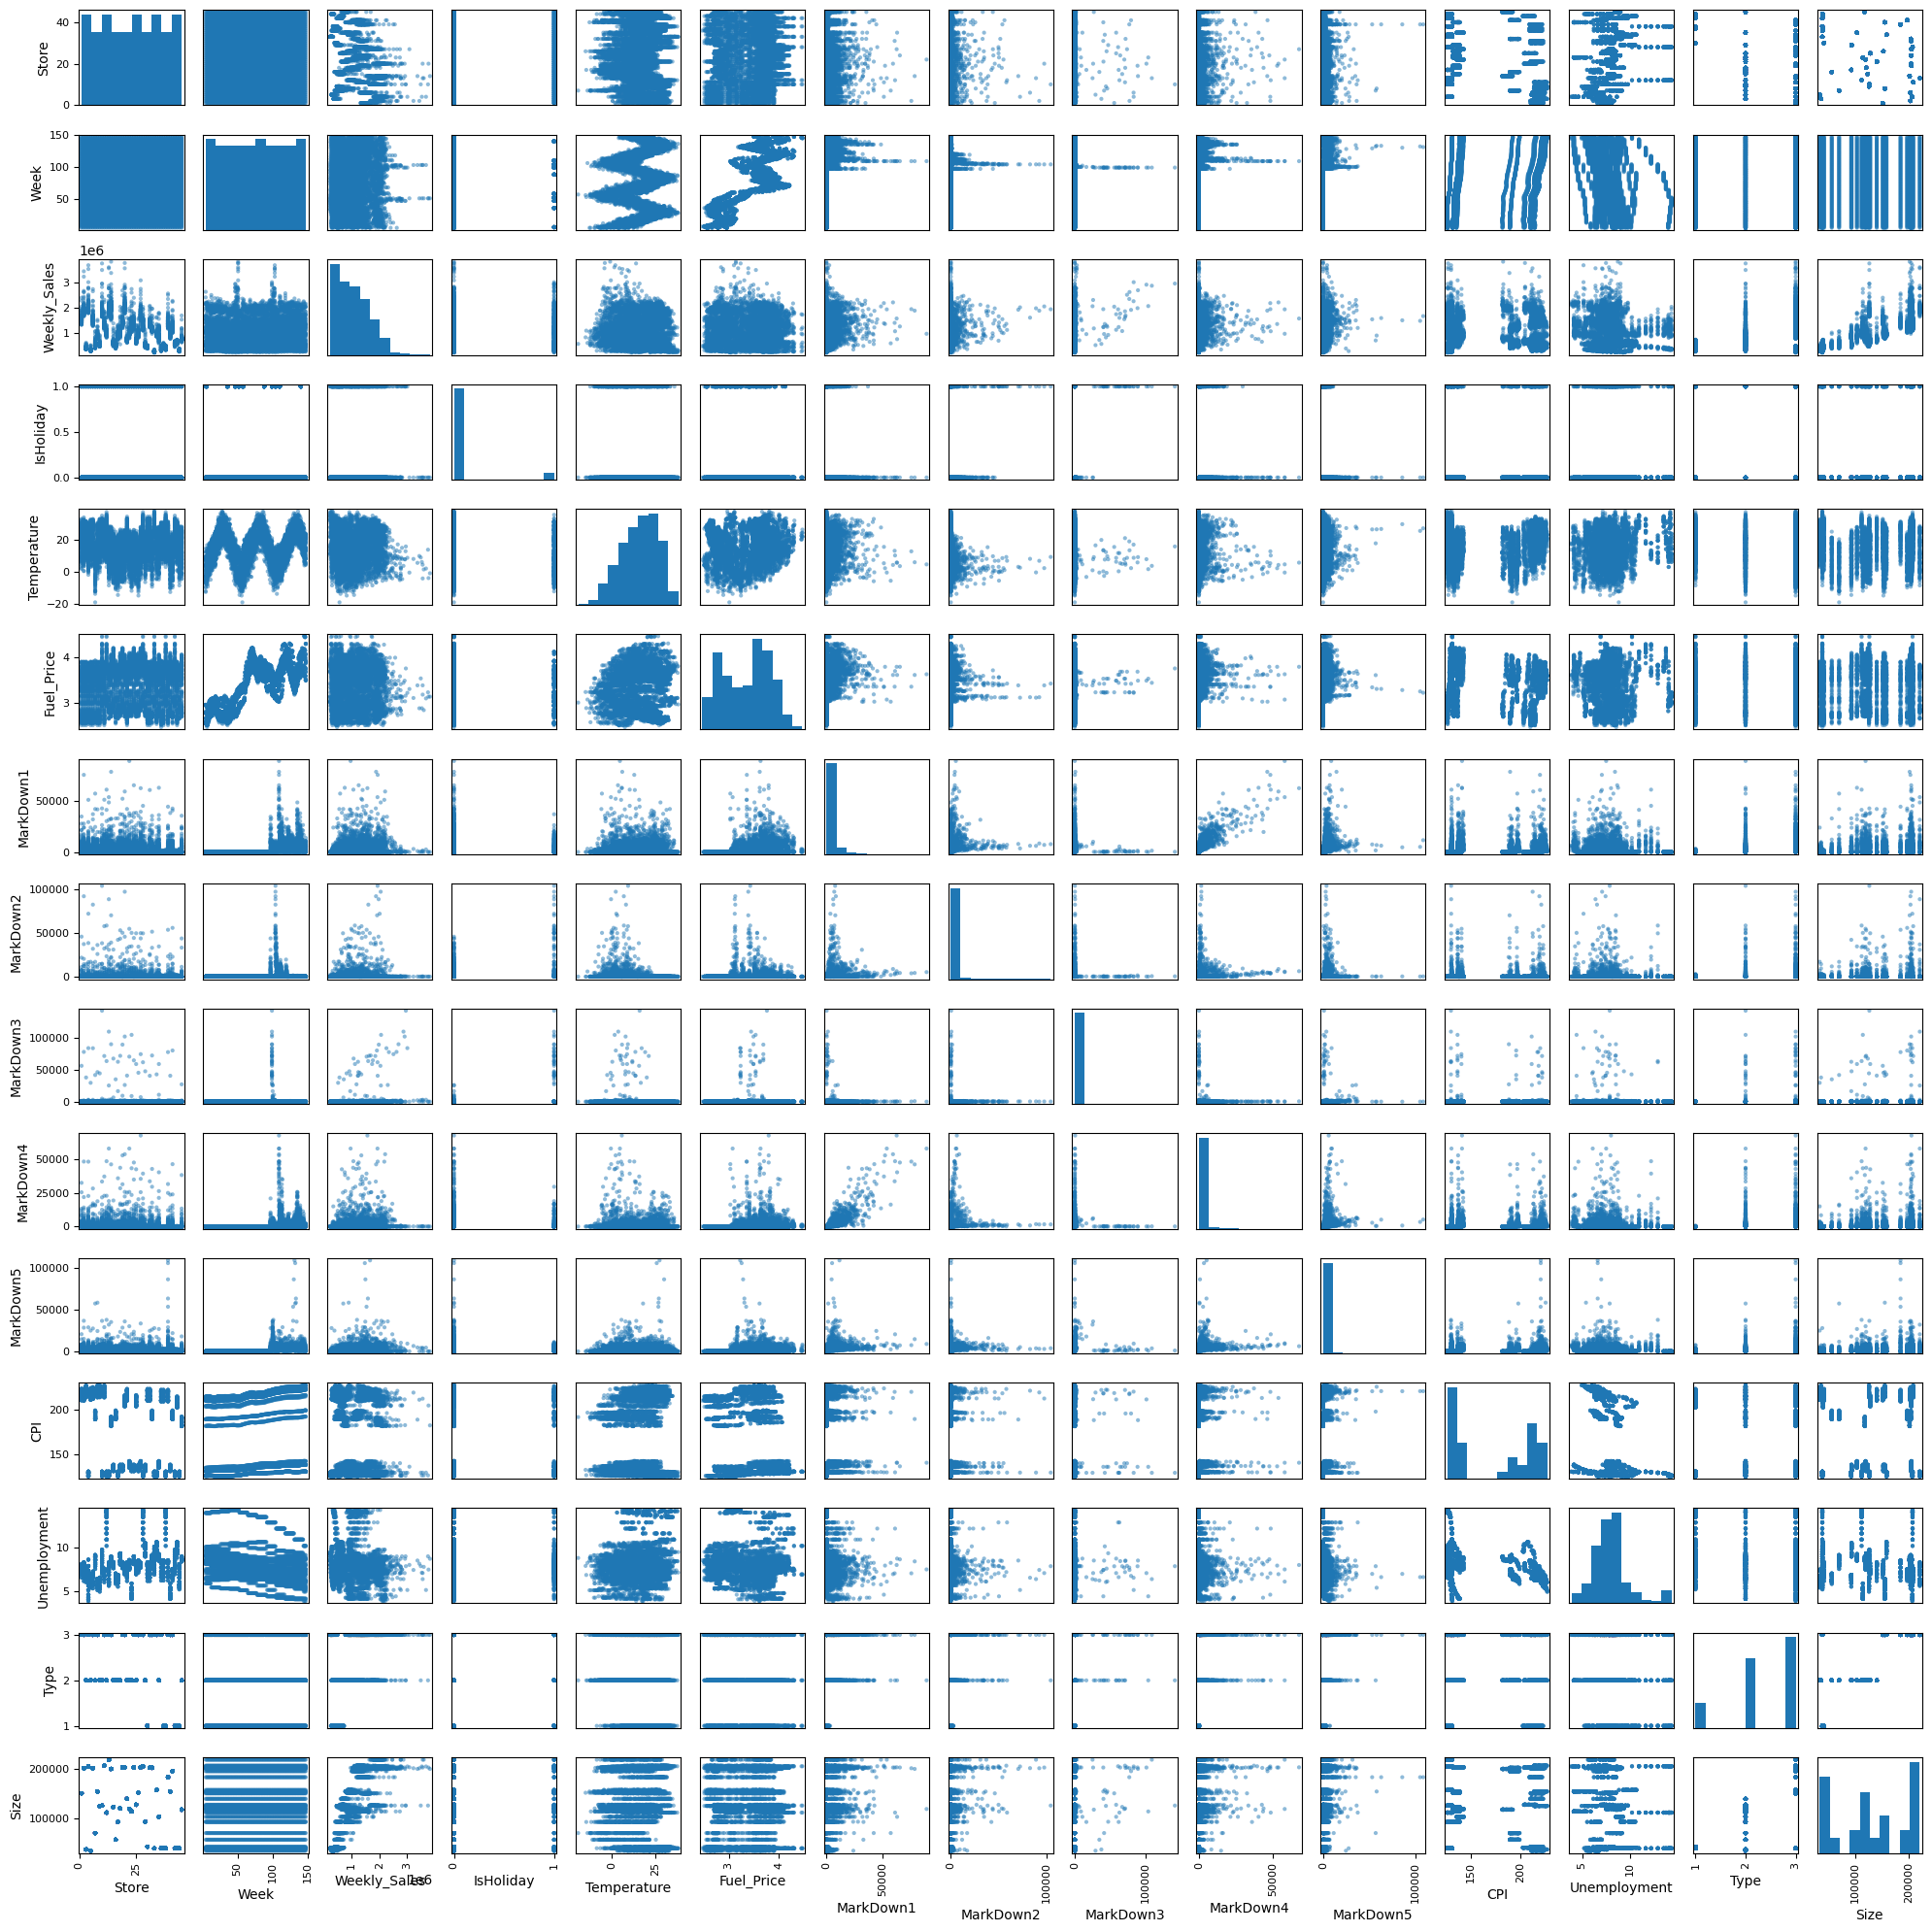

In [ ]:
start_year = df["Date"].dt.year.min()
df_with_weeks = df.copy()
df_with_weeks["Week"] = (
    df_with_weeks["Date"].dt.isocalendar().week
    + (df_with_weeks["Date"].dt.year - start_year) * 52
)
# df_with_weeks = (df_with_weeks.groupby(['Store']))['Weekly_Sales'].mean().reset_index()
df_with_weeks_agg_Dept = smart_aggregate(
    df_with_weeks, ["Store", "Week"], "Weekly_Sales"
)
df_with_weeks_agg_Dept.pop("Dept")
# df_with_weeks_agg_Dept.tail()

pd.plotting.scatter_matrix(df_with_weeks_agg_Dept, figsize=(20, 20), diagonal="hist")
plt.tight_layout()
plt.show()

Additoinally here is the correlation matrix, this time including the Department 

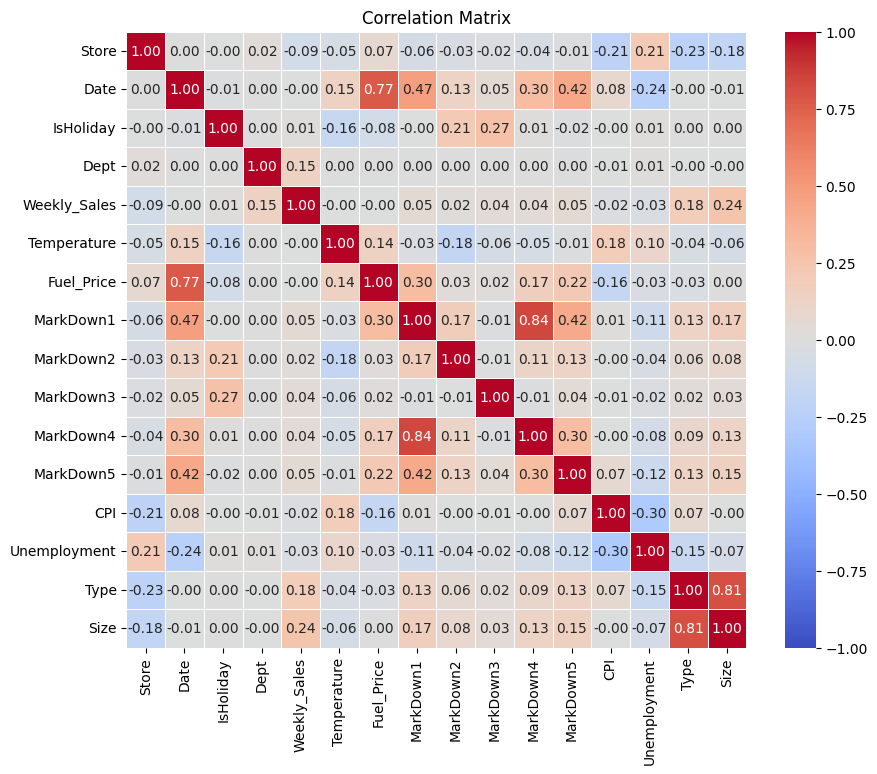

In [14]:
# Heatmap of the correlation matrix
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f", linewidths=0.5
)
plt.title("Correlation Matrix")
plt.show()

# Observations:
1. Promotions:
    - We see a correlations in different degrees between four of the five Promotions (excluding no.3). However from their time series we also see that data for the promotions starts only after a given date. To be able to conclude if the promotions indeed tent to be placed together, an observation of only that part of the series should be made (see below)

    - Another observation is that promotions 2 and 3 are positively correlated to IsHoliday, while the other 3 have a (different) dependence on the date.

    - Lastly, from the calculated coefficient no correlation , so more investigation could be made

2. Department:
    - Is indeed least correlated to anything, so the made aggregation is justified

3. Size and Type of the store.
 #TODO - make more plots, could even try to run a classificator for the type given, let's say the size and the sales, in a sort of reverse engineering

4. Time correlations:
   - Some features are (expectedly) correlated on the time and often the same feature is dependent on the Store (i.e. the place). Examples for such features are: Temperature, Fuel_Price, CPI, Unemployment. 

Let's make a similar study, but focusing on the promotions and starting from the date they start (11-11-2011).

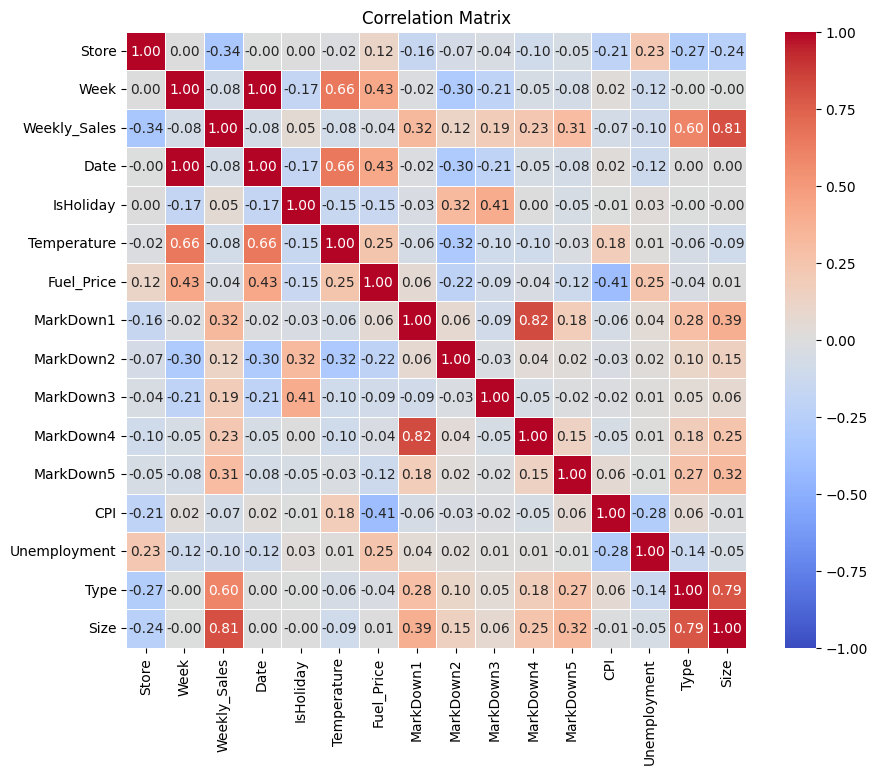

In [ ]:
df_Promotions_no_Dept = df_with_weeks_agg_Dept[df_with_weeks_agg_Dept["Date"] >= "11-11-11"]

corr_matrix = df_Promotions_no_Dept.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f", linewidths=0.5
)
plt.title("Correlation Matrix")
plt.show()

We plot the the Sales as a function of the magnitude of each promotion. As the ranges for both the sales and the promotions are big a log-log scale is used. To also check whether some promotion ranges are tight to the type of the store we seperate the data for each promotion by Type.

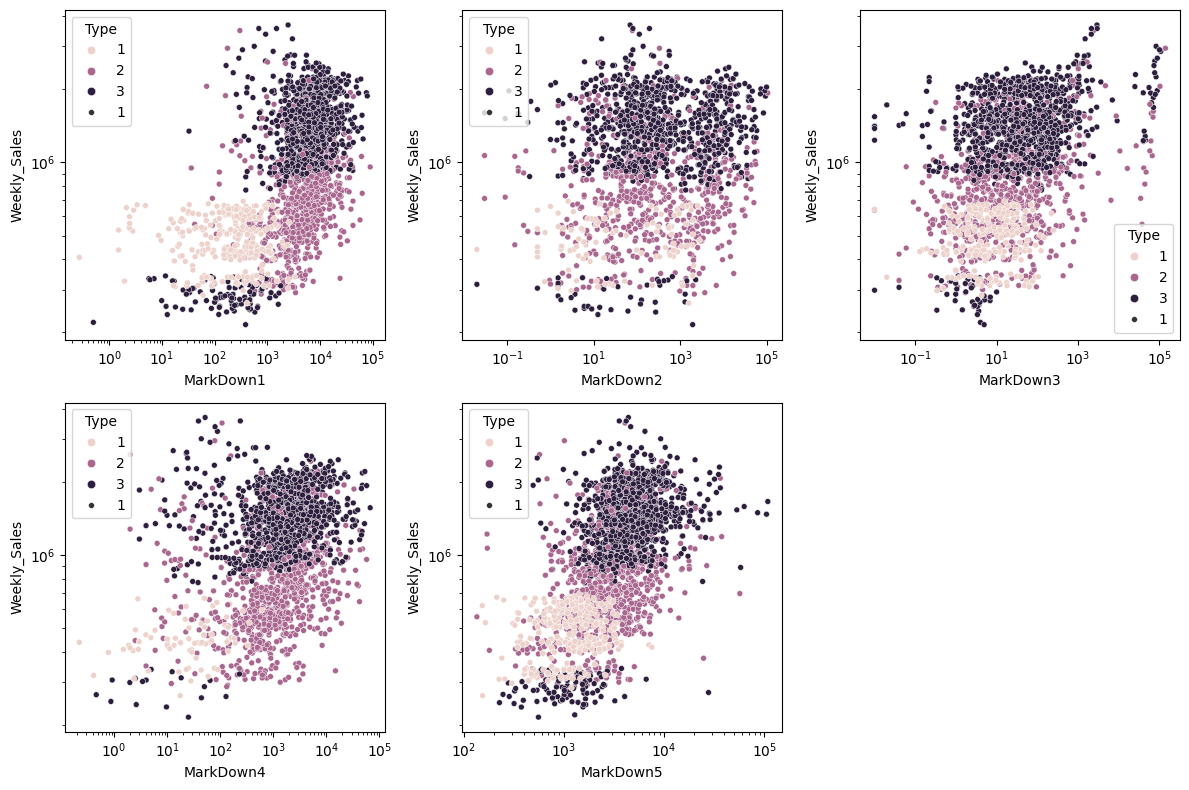

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(1, 6):
    sns.scatterplot(
        data=df_Promotions_no_Dept,
        x=f"MarkDown{i}",
        y="Weekly_Sales",
        hue="Type",
        ax=axes[i - 1],
        size=1,
        legend=True,
    )
    axes[i - 1].set_xscale("log")
    axes[i - 1].set_yscale("log")

axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# LOg-LOG linear fit but, a bit complicated and not worth it

# fig, axes = plt.subplots(2, 3, figsize=(12, 8))
# axes = axes.flatten()

# for i in range(1, 6):
#     sns.scatterplot(
#         data=df_Promotions_no_Dept,
#         x=f"MarkDown{i}",
#         y="Weekly_Sales",
#         # hue="Type",
#         ax=axes[i-1],
#         size=1
#     )

#     sns.regplot(
#         data=df_Promotions_no_Dept,
#         x=f"MarkDown{i}",
#         y="Weekly_Sales",
#         scatter=False,
#         ci=None,
#         color="red",
#         ax=axes[i-1]
#     )

#     axes[i-1].set_xscale("log")
#     axes[i-1].set_yscale("log")

# axes[-1].set_visible(False)

# plt.tight_layout()
# plt.show()

In [ ]:
print(df_Promotions_no_Dept["Type"].unique())
print(df_Promotions_no_Dept["Type"].isna().sum())
print(df_Promotions_no_Dept["Type"].map(type).unique())
print(df_Promotions_no_Dept["Type"].dtype)

[3 2 1]
0
[<class 'int'>]
int64


Also over time?

In [ ]:
# df_Promotions_no_Dept_avg = df_Promotions_no_Dept.groupby(["Date", "Type"], as_index=False)[["MarkDown1", "MarkDown2", "MarkDown3","MarkDown4","MarkDown5", "Weekly_Sales"]].mean()

# df_Promotions_no_Dept_avg.head(250)

# fig, axes = plt.subplots(3, 3, figsize=(19, 18))
# axes = axes.flatten()

# toPlot = ["MarkDown1", "MarkDown2", "MarkDown3","MarkDown4","MarkDown5", "Weekly_Sales", "IsHoliday"]


# for i, (y) in enumerate(toPlot):
#     sns.scatterplot(
#         data=df_Promotions_no_Dept_avg,
#         x="Date",
#         y=y,
#         ax=axes[i-1],
#         size=0.1,
#         legend=False
#     )
#     axes[i-1].tick_params(axis="x", rotation=45, labelsize=6)
#     # axes[i-1].set_xscale("log")
#     axes[i-1].set_yscale("log")

# # axes[-1].set_visible(False)

# plt.tight_layout()
# plt.show()

Interesting questions to ask:

given the weekly sales (and size) try to classify the type 

# 2. Prediction models 

### Note: Because of the observations made above, it seems interesting to run prediction models on different subparts of the data and to observe for differences:
 - Only the data that includes the promotions 
 - The data for all date, but excluding the promotions all together
 - The full data

### As for the used models, we stick to the most popular
 - Random forest regressor; a variation of the number of estimator could also be made 
 - k nearest neighbors, with variation of k

In [108]:
# Let's define some possible subsets 

df_Promotions = df_with_weeks[df_with_weeks["Date"] >= "11-11-11"]

df_Promotions_agg_Dept = smart_aggregate(
    df_Promotions, ["Store", "Week"], "Weekly_Sales"
).drop(columns=["Dept"])

df_agg_Dept = smart_aggregate(
    df_with_weeks, ["Store", "Week"], "Weekly_Sales"
).drop(columns=["Dept"])

df_no_Promo = df_with_weeks.drop(columns=["MarkDown1", "MarkDown2", "MarkDown3","MarkDown4","MarkDown5"])


df_no_Promo_agg_Dept = smart_aggregate(
    df_no_Promo, ["Store", "Week"], "Weekly_Sales"
).drop(columns=["Dept"])

# Check the dimentions
print()
dfs = {
    "df_Promotions": df_Promotions,
    "df_Promotions_agg_Dept": df_Promotions_agg_Dept,
    "df_agg_Dept": df_agg_Dept,
    "df_no_Promo": df_no_Promo,
    "df_no_Promo_agg_Dept": df_no_Promo_agg_Dept,
    "df_full": df_with_weeks
}

for name, df in dfs.items():
    print(f"{name}: shape = {df.shape}")


Column 'Dept' has conflicting values within groups.
Column 'Dept' has conflicting values within groups.
Column 'Dept' has conflicting values within groups.

df_Promotions: shape = (151432, 17)
df_Promotions_agg_Dept: shape = (2295, 16)
df_agg_Dept: shape = (6435, 16)
df_no_Promo: shape = (421570, 12)
df_no_Promo_agg_Dept: shape = (6435, 11)
df_full: shape = (421570, 17)


## 2.1 Random Forest

### 2.1.1 Only data with promotions - one tree

In [105]:
df1 = df_Promotions.copy()

y = df1["Weekly_Sales"]
X = df1.drop(["Weekly_Sales", "Date"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

n_estimators = 1

clf = RandomForestRegressor(n_estimators=n_estimators, random_state=seed)
forest1 = clf.fit(X_train, y_train)

y_pred = forest1.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
# mape = mean_absolute_percentage_error(y_test, y_pred) <------ not useful as some y are close to 0

r2 = r2_score(y_test, y_pred)

importances = pd.Series(forest1.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(f"One tree")
print(f"Mean Squared Error: {mse:.4f}")
# print(f"Mean Absolute Percentage Errorr: {mape:.4f}")
print(f"R² Score: {r2:.4f}")

One tree
Mean Squared Error: 42329083.6512
R² Score: 0.9209


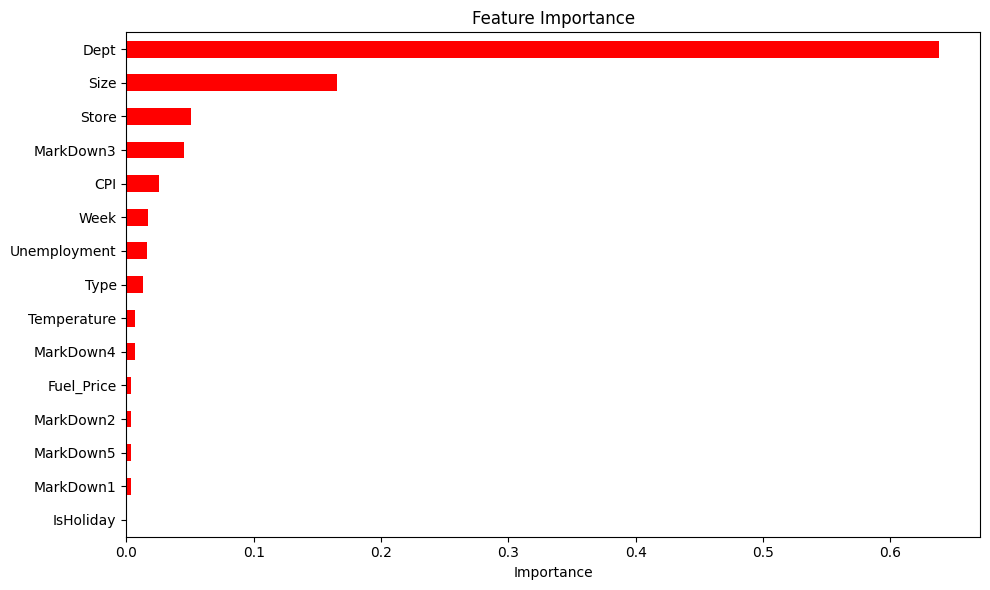

In [33]:
importances = pd.Series(forest1.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind="barh", figsize=(10, 6), color="r")
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

As mentioned in the initial analysis as the variance of the sales over the departments is the highest it is no surprise that the predictor put the most importance on it.

Resudual analysis:

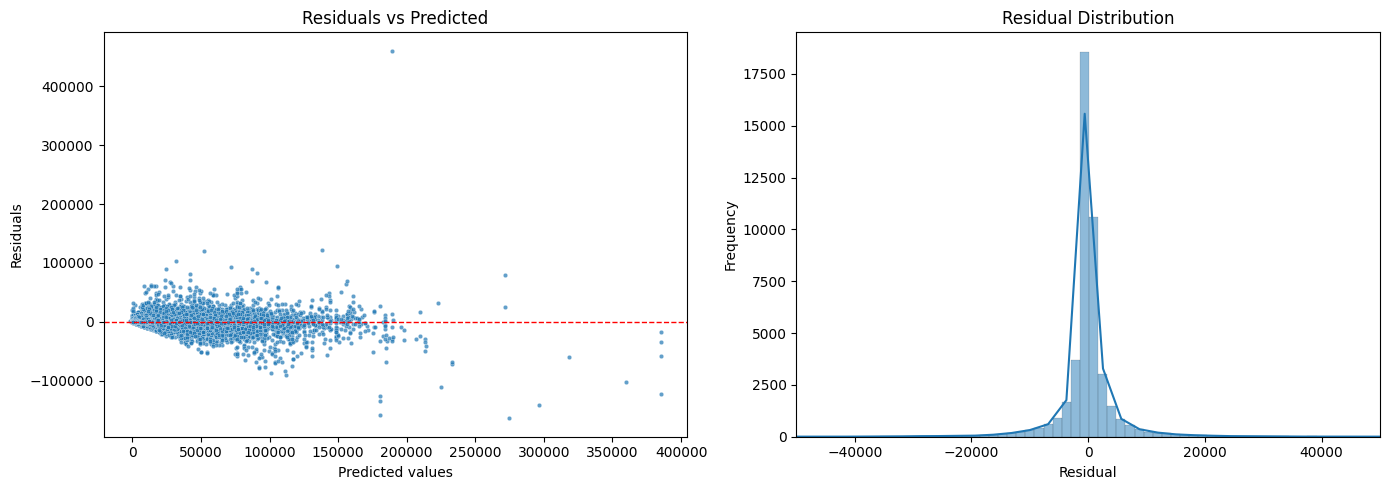

In [53]:
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Residuals vs Predicted
sns.scatterplot(x=y_pred, y=residuals, ax=axes[0], s=10, alpha=0.7)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_title("Residuals vs Predicted")
axes[0].set_xlabel("Predicted values")
axes[0].set_ylabel("Residuals")

# 2. Residual Distribution
sns.histplot(residuals, kde=True, ax=axes[1], bins=400)
axes[1].set_xlim(-50_000, 50_000)
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


As the residuals are randomly distributed the model has no bias. Still, the rarer high values have higher residuals and there is one extremely high value that was predicted to a 1/3 of the actual. As this is the rarest value it could be considered an outlier. 

Metrics and export of the actual tree:

In [42]:
tree = forest1.estimators_[0]

print(f"Max debth: {tree.tree_.max_depth}")
print(f"Nodes = {tree.tree_.node_count}")

print(f"Features = {tree.tree_.feature}")
# print(f"Features = {tree.tree_.threshold}")

print()
print(export_text(tree, feature_names=list(X.columns)))

# dot = export_graphviz(
#     tree,
#     out_file=None,
#     feature_names=X.columns,
#     filled=True,
#     rounded=True
# )

# graph = graphviz.Source(dot)
# graph

#####################################################################################
#          WORKS BUT YOU NEED TO INTALL GRAPHIZ ADDITIONALLY   (beside pip)         #
#          PLEASE SEE THE .PDF FILE                                                 #
#####################################################################################


Max debth: 39
Nodes = 133371
Features = [ 2  2 13 ... -2 -2 -2]

|--- Dept <= 88.50
|   |--- Dept <= 10.50
|   |   |--- Size <= 81950.50
|   |   |   |--- Store <= 23.00
|   |   |   |   |--- CPI <= 199.18
|   |   |   |   |   |--- Dept <= 8.50
|   |   |   |   |   |   |--- Dept <= 2.50
|   |   |   |   |   |   |   |--- Dept <= 1.50
|   |   |   |   |   |   |   |   |--- Week <= 119.50
|   |   |   |   |   |   |   |   |   |--- MarkDown2 <= 3.28
|   |   |   |   |   |   |   |   |   |   |--- MarkDown4 <= 314.39
|   |   |   |   |   |   |   |   |   |   |   |--- value: [10826.10]
|   |   |   |   |   |   |   |   |   |   |--- MarkDown4 >  314.39
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- MarkDown2 >  3.28
|   |   |   |   |   |   |   |   |   |   |--- Temperature <= -8.27
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- Temperature >  -8.27
|   |   |   |   |

Let's try observing what are limits used as bounds for each feature:

In [54]:

def summarize_split_thresholds(rf, feature_names):
    # Collect thresholds per feature
    thresholds = {f: [] for f in feature_names}

    for tree in rf.estimators_:
        t = tree.tree_
        for node_id in range(t.node_count):
            feature_id = t.feature[node_id]
            threshold = t.threshold[node_id]

            # Skip leaf nodes (feature_id = -2)
            if feature_id >= 0:
                feature_name = feature_names[feature_id]
                thresholds[feature_name].append(threshold)

    # Build summary table
    summary = []
    for feature, values in thresholds.items():
        if values:
            arr = np.array(values)
            summary.append({
                "feature": feature,
                "splits": len(arr),
                "min_threshold": arr.min(),
                "max_threshold": arr.max(),
                "median_threshold": np.median(arr),
                "unique_thresholds": len(np.unique(arr))
            })
        else:
            summary.append({
                "feature": feature,
                "splits": 0,
                "min_threshold": None,
                "max_threshold": None,
                "median_threshold": None,
                "unique_thresholds": 0
            })

    return pd.DataFrame(summary)


summary_df = summarize_split_thresholds(forest1, X.columns)
print(summary_df)

         feature  splits  min_threshold  max_threshold  median_threshold  \
0          Store    1822       1.500000      43.500000         22.000000   
1      IsHoliday     577       0.500000       0.500000          0.500000   
2           Dept    1506       1.500000      98.500000         32.500000   
3    Temperature    6725     -12.602777      37.283333         16.558333   
4     Fuel_Price    6448       3.034500       4.458500          3.675500   
5      MarkDown1    6868       0.135000   67039.154297       5517.479980   
6      MarkDown2    5593    -128.130005   96820.738281        185.470001   
7      MarkDown3    6685     -14.550000  125330.679688         24.930000   
8      MarkDown4    5976       0.110000   50881.923828       1568.359987   
9      MarkDown5    6964     254.004997  106871.195312       3412.755066   
10           CPI    6317     129.821770     227.223549        173.933540   
11  Unemployment    3551       3.978000      12.538500          7.249000   
12          

### 2.1.2 Only data with promotions - increasing number of trees

In [ ]:
df1 = df_Promotions.copy()

y = df1["Weekly_Sales"]
X = df1.drop(["Weekly_Sales", "Date"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

n_list = [1, 2, 5, 10, 15, 20, 30]

mse_list = []
r2_list = []
importance_list = []

for i in n_list: 
    n_estimators = i

    clf = RandomForestRegressor(n_estimators=n_estimators, random_state=seed)
    forest = clf.fit(X_train, y_train)

    y_pred = forest.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # tree = forest.estimators_[0]
    
    mse_list.append(mse)
    r2_list.append(r2)
    
    
    importances = pd.Series(forest.feature_importances_, index=X_train.columns)
    importance_list.append(importances)

    

Text(0, 0.5, 'R²')

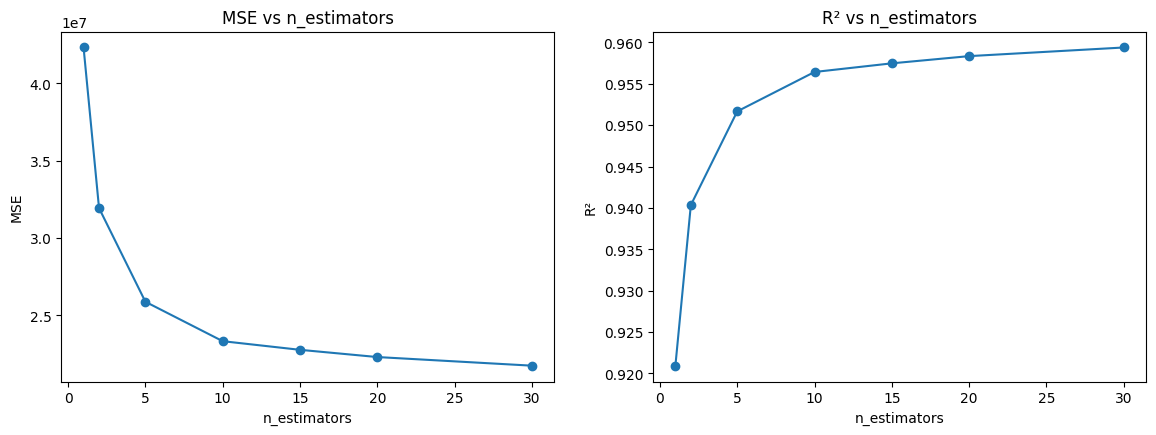

In [73]:
plt.figure(figsize=(14, 10))

# MSE
plt.subplot(2, 2, 1)
plt.plot(n_list, mse_list, marker="o")
plt.title("MSE vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("MSE")

# R2
plt.subplot(2, 2, 2)
plt.plot(n_list, r2_list, marker="o")
plt.title("R² vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("R²")


We see that the importance imporoves, but decreasingly so after n = 10;

For future comparisons this value would be used.

C:\Users\radok\AppData\Local\Temp\ipykernel_34776\1610259415.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=14.0)


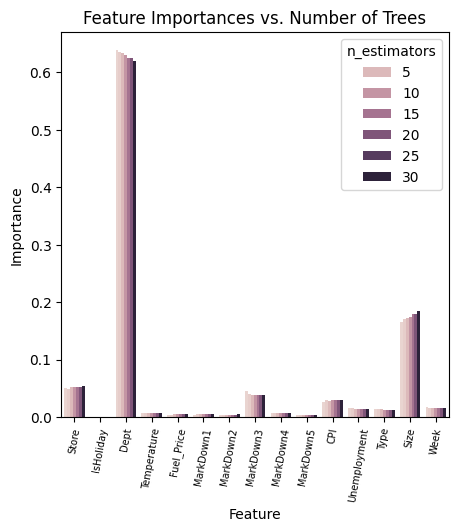

In [78]:
importance_df = pd.DataFrame(importance_list, index=n_list)
importance_df = importance_df[X_train.columns]

importance_df.head()

df_long = (
    importance_df
    .reset_index()
    .melt(id_vars="index", var_name="feature", value_name="importance")
    .rename(columns={"index": "n_estimators"})
)

plt.figure(figsize=(5, 5))

sns.barplot(
    data=df_long, x="feature", y="importance", hue="n_estimators"
)

plt.title("Feature Importances vs. Number of Trees")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.legend(title="n_estimators")
plt.xticks(rotation=80, fontsize=7)
plt.tight_layout(pad=14.0)
plt.show()


The relative importances change a little, but with a trend from the first one - Department to the second - the size.

#### In conlcusion: 
- The random forest model seem to predict the sales to a good degree.
- The model learned a cross‑sectional differences between the department and stores.
- Even tough the data is a time seriece the time (week) turn out to be not that importnat of a factor. This could also be due to the shorter period we used so far. To test for future forcasting it may be good to split a continius period of time as test dataset #TODO 


### 2.1.3 Differnt data subsets: promotions only vs. all time no promotions vs. all time with promotions


df_Promotions: shape = (151432, 17)
Mean Squared Error: 22907023.0571
R² Score: 0.9572


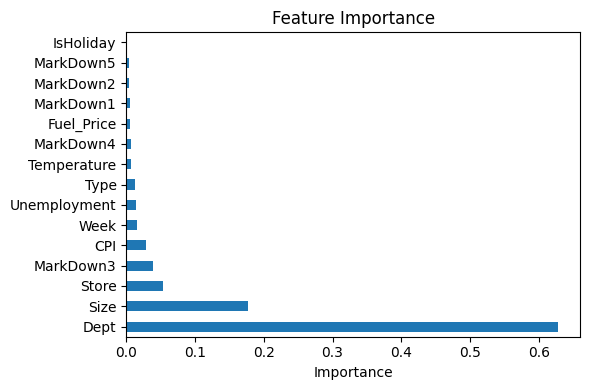


df_Promotions_agg_Dept: shape = (2295, 16)
Mean Squared Error: 15188495909.0126
R² Score: 0.9538


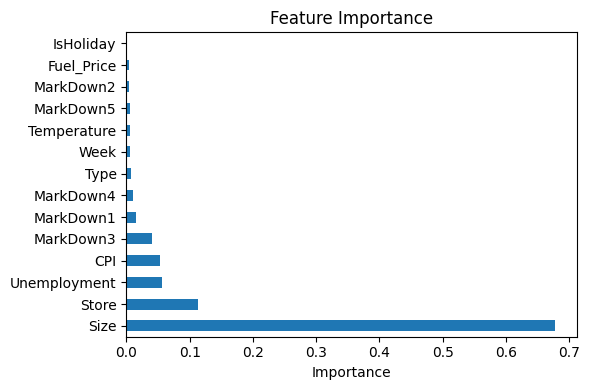


df_agg_Dept: shape = (6435, 16)
Mean Squared Error: 16230276617.1461
R² Score: 0.9492


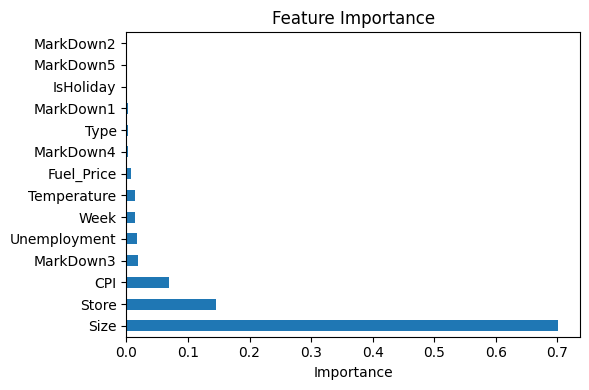


df_no_Promo: shape = (421570, 12)
Mean Squared Error: 28110885.7062
R² Score: 0.9454


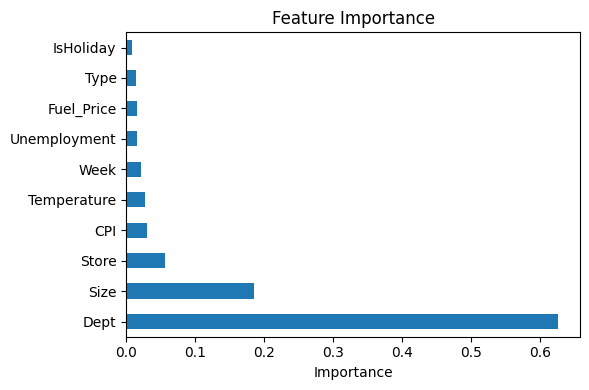


df_no_Promo_agg_Dept: shape = (6435, 11)
Mean Squared Error: 19092650750.0885
R² Score: 0.9403


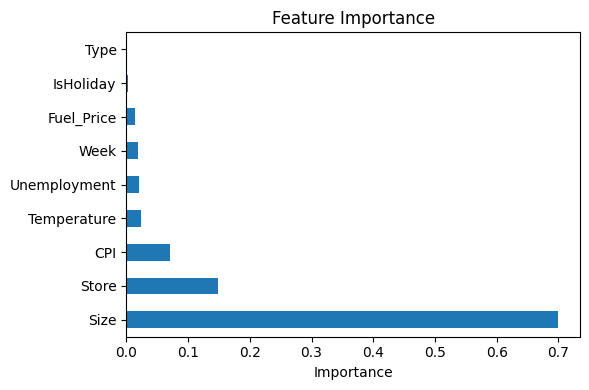


df_full: shape = (421570, 17)
Mean Squared Error: 24778484.0074
R² Score: 0.9519


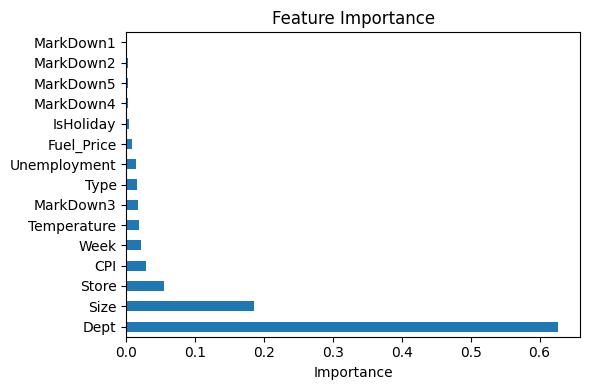

In [111]:
for name, df in dfs.items():
    print()
    print(f"{name}: shape = {df.shape}")
    
    y = df["Weekly_Sales"]
    X = df.drop(["Weekly_Sales", "Date"], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed
    )

    n_estimators = 12

    clf = RandomForestRegressor(n_estimators=n_estimators, random_state=seed)
    forest1 = clf.fit(X_train, y_train)

    y_pred = forest1.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)

    importances = pd.Series(forest1.feature_importances_, index=X_train.columns).sort_values(ascending=False)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    importances.plot(kind="barh", figsize=(6, 4))
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

The preformance in all cases is good. 

Dropping features does not effect the relative importance of the rest.

The case of the full data set (last one), comapred to only the weeks with promotions (first) shows the expeced drop in importance of the promotions, but does not effect the predicting power.

## 2.2 K-neasrest neighbours

In [103]:
df1 = df_Promotions.copy()

def runKNN(df):
    
    y = df["Weekly_Sales"]
    X = df.drop(["Weekly_Sales", "Date"], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed
    )

    k_values = [5, 10, 20, 50, 80, 120]
    results = []

    for k in k_values:
        knn = Pipeline([
            ("scaler", StandardScaler()),
            ("model", KNeighborsRegressor(n_neighbors=k))
        ])
        
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append((k, mse, r2))

    for k, mse, r2 in results:
        print(f"k={k:2d}  MSE={mse:.4f}  R²={r2:.4f}")
        
runKNN(df1)


k= 5  MSE=426417083.5930  R²=0.2035
k=10  MSE=437140944.4905  R²=0.1835
k=20  MSE=413727522.6599  R²=0.2272
k=50  MSE=414266785.9753  R²=0.2262
k=80  MSE=417689417.2410  R²=0.2198
k=120  MSE=421588611.1762  R²=0.2125


It seems like there is jsut not enough data for the number of dimentions. 

We could try to run it on easy mode excluding some dimentions. #TODO

In [104]:
df1 = df_Promotions.copy()

runKNN(df_no_Promo)

k= 5  MSE=342662209.8081  R²=0.3342
k=10  MSE=327781462.1124  R²=0.3631
k=20  MSE=331878337.1719  R²=0.3552
k=50  MSE=351390211.3438  R²=0.3173
k=80  MSE=360872249.3525  R²=0.2989
k=120  MSE=367914225.4261  R²=0.2852


Still no good and also slower than the forest 

## 2.3 LightGBM - decision trees build with gradient boosting 

In [135]:
df = df_with_weeks
y = df["Weekly_Sales"]
X = df.drop(["Weekly_Sales", "Date"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

def runLGBMR(n):
    model = LGBMRegressor(
        n_estimators=n,
        learning_rate=0.05,
        max_depth=-1,          # -1 means no limit
        num_leaves=50,         # default, good starting point
        subsample=0.8,         # row sampling
        colsample_bytree=0.8,  # feature sampling
        random_state=seed
    )

    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print()
    print(f"n_estimators: {n}")
    # leaves = np.mean([est.num_leaves_ for est in model.booster_.trees_to_dataframe()['tree_index'].unique()])
    # print(f"trees: {model.booster_.trees_to_dataframe()}")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")

    # Feature importances
    importances = pd.Series(model.feature_importances_, index=X_train.columns)
    print(importances.sort_values(ascending=False))
    


In [136]:
runLGBMR(4_000)    

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2602
[LightGBM] [Info] Number of data points in the train set: 295099, number of used features: 15
[LightGBM] [Info] Start training from score 15991.078692

n_estimators: 4000
MSE: 13228083.8042
R²: 0.9743
Dept            47570
Week            21991
Store           19972
Temperature     19419
Size            17782
CPI             16139
Fuel_Price      14510
Unemployment    12396
MarkDown3        6007
MarkDown4        3864
MarkDown2        3844
MarkDown5        3839
MarkDown1        3635
Type             3415
IsHoliday        1617
dtype: int32


A few trials were made incerasing n_estimators to roughly see up to when there is a significant gain.

This result is sligtly better than the random forest which was R^2 = 0.9519 for the same dataset.

In [137]:
runLGBMR(100)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2602
[LightGBM] [Info] Number of data points in the train set: 295099, number of used features: 15
[LightGBM] [Info] Start training from score 15991.078692

n_estimators: 100
MSE: 60944957.1197
R²: 0.8816
Dept            1915
Store            756
Size             679
CPI              353
Week             304
MarkDown3        213
Temperature      176
Type             161
Unemployment     153
Fuel_Price        71
MarkDown4         42
IsHoliday         35
MarkDown5         17
MarkDown1         15
MarkDown2         10
dtype: int32


In [ ]:
# model = LGBMRegressor(
#     n_estimators=50,
#     learning_rate=0.05,
#     max_depth=-1,          # -1 means no limit
#     num_leaves=50,         # default, good starting point
#     subsample=0.8,         # row sampling
#     colsample_bytree=0.8,  # feature sampling
#     random_state=seed
# )

# model.fit(X_train, y_train)
    
# create_tree_digraph(
#     model,
#     tree_index=0,
#     name="lightgbm_tree"
# ).render("lightgbm_tree", format="pdf")


# see the .pdf


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2602
[LightGBM] [Info] Number of data points in the train set: 295099, number of used features: 15
[LightGBM] [Info] Start training from score 15991.078692


'lightgbm_tree.pdf'

## 2.4 ElasticNet - linear regression with both L1 and L2 regularization


In [149]:
def runElasicNet(df):
    y = df["Weekly_Sales"]
    X = df.drop(["Weekly_Sales", "Date"], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed
    )

    # ElasticNet pipeline (scaling is essential)
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("enet", ElasticNet(alpha=0.3, l1_ratio=0.8, random_state=seed))
    ])

    # Fit
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")

    # Coefficients
    coefs = model.named_steps["enet"].coef_
    coef_df = pd.DataFrame({"feature": X_train.columns, "coef": coefs})
    print(coef_df.sort_values("coef", key=abs, ascending=False))
    
runElasicNet(df_with_weeks)   


MSE: 471167418.5876
R²: 0.0846
         feature         coef
13          Size  5249.507385
2           Dept  3234.082331
0          Store -1119.966621
10           CPI  -731.176990
7      MarkDown3   659.947768
9      MarkDown5   460.248687
3    Temperature   436.549969
12          Type  -391.062989
14          Week  -317.244268
11  Unemployment  -305.610317
1      IsHoliday   165.832864
8      MarkDown4    74.866439
4     Fuel_Price   -60.280895
5      MarkDown1    42.785288
6      MarkDown2    32.834660


The linear model performs expetedly bad as (as we saw in the scatter plot matrix there) the relations are a strongly non linear.

Let's give it a try atleast witout the Department (which was the highest variance)


In [150]:
runElasicNet(df_agg_Dept)   


MSE: 99066371430.2935
R²: 0.6901
         feature           coef
13          Size  416182.363256
0          Store  -89737.741448
10           CPI  -60819.782647
7      MarkDown3   46710.244658
9      MarkDown5   29135.338461
11  Unemployment  -25776.029656
3    Temperature   24710.614016
12          Type  -18739.193120
1           Week  -13508.856956
2      IsHoliday   12300.241458
4     Fuel_Price   -8360.364773
5      MarkDown1    7651.729215
6      MarkDown2    4317.414057
8      MarkDown4    3208.508464


In [151]:
runElasicNet(df_Promotions_agg_Dept)   


MSE: 95711650412.0284
R²: 0.7091
         feature           coef
13          Size  416943.853978
0          Store  -88855.844575
10           CPI  -70964.081658
7      MarkDown3   69824.195325
1           Week  -58868.780806
3    Temperature   52624.409599
11  Unemployment  -48225.721669
9      MarkDown5   44062.754225
12          Type  -24805.908561
4     Fuel_Price  -11922.052165
8      MarkDown4    8065.376156
5      MarkDown1    5286.786532
2      IsHoliday   -1118.001882
6      MarkDown2    -550.781352


#### Conclusion: Even though in this case it performs better it is still far worse than the decision tree. The regression is limited and not well fitted for the use case.